In [ ]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import operator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
import pandas as pd
from sklearn.metrics import r2_score
from jostar.algorithms import ACO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define parameters
num_ants = 4
num_iterations = 5
q0 = 0.5
alpha = 1.0
beta = 0.7
rho = 0.45

In [5]:
data = pd.read_csv("pavdatfinal2.csv")

In [6]:
data.head()

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,NL,...,TNLM,TNLPA,TNLPM,TNLS,TNM,TNOS,TNPA,TNPM,TNS,bug
0,0.000000,0,0,0,0.000000,0.000000,0,0,1,0,...,4,0,2,0,11,6,0,7,0,0
1,0.178218,1,2,2,0.166667,0.153846,26,18,2,0,...,9,0,7,0,45,87,1,37,0,0
2,0.000000,0,0,0,0.000000,0.000000,0,0,1,0,...,3,0,3,0,11,4,0,11,0,0
3,0.000000,0,0,0,0.000000,0.000000,0,0,1,1,...,5,0,5,0,5,17,0,5,0,0
4,0.000000,0,0,0,0.000000,0.000000,0,0,1,1,...,7,0,7,0,17,30,0,17,1,0


In [7]:
X = data.drop(['bug'], axis = 1)
y = data['bug']
X.head()

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,NL,...,TNLG,TNLM,TNLPA,TNLPM,TNLS,TNM,TNOS,TNPA,TNPM,TNS
0,0.000000,0,0,0,0.000000,0.000000,0,0,1,0,...,0,4,0,2,0,11,6,0,7,0
1,0.178218,1,2,2,0.166667,0.153846,26,18,2,0,...,2,9,0,7,0,45,87,1,37,0
2,0.000000,0,0,0,0.000000,0.000000,0,0,1,0,...,1,3,0,3,0,11,4,0,11,0
3,0.000000,0,0,0,0.000000,0.000000,0,0,1,1,...,0,5,0,5,0,5,17,0,5,0
4,0.000000,0,0,0,0.000000,0.000000,0,0,1,1,...,2,7,0,7,0,17,30,0,17,1


In [8]:
X.shape,y.shape

((17560, 60), (17560,))

In [9]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12292, 60), (12292,), (5268, 60), (5268,))

In [10]:
pheromone = np.random.rand(X.shape[1])
print(pheromone.shape)

(60,)


In [11]:
# Define fitness function
def fitness(X, y, pheromone):
    ran = np.random.rand(X.shape[1])
    # print(pheromone)
    # print(ran)
    selected_features = np.where(ran < pheromone)[0]
    # print(selected_features)
    if len(selected_features) == 0:
        return 0.0
#     clf = SVC()

#     clf =  DecisionTreeClassifier()

    clf =  RandomForestClassifier(n_estimators=10)
    clf.fit(X.iloc[:, selected_features], y)
    y_pred = clf.predict(X_test.iloc[:, selected_features])
    # print(y_test)
    # print(y_pred)
    return accuracy_score(y_test, y_pred)
# print(fitness(X_train,y_train,pheromone))

In [ ]:
# Initialize best solution and its fitness
best_solution = None
best_fitness = 0.0

# Run the ACO algorithm
for iteration in range(num_iterations):
    # Initialize ant solutions
    print("Iteration: ", iteration)
    solutions = np.zeros((num_ants, X_train.shape[1]))
    # print(iteration," : ",solutions,"\n")
    for ant in range(num_ants):
        for feature in range(X_train.shape[1]):
            r = np.random.rand()
            if r < q0:
                solutions[ant, feature] = 1
                # print("In if:", solutions,"\n")
            else:
                probabilities = pheromone ** alpha * (1.0 / fitness(X_train, y_train, pheromone)) ** beta
                probabilities /= np.sum(probabilities)
                # print("probabilities",probabilities)
                pro = probabilities[feature]
                # print("Probabilites sum: ", np.sum(probabilities))
                # solutions[ant, feature] = np.random.choice([0, 1], p=probabilities)
                solutions[ant, feature] = np.random.choice([0, 1], p=[1-pro,pro])
                # print("In else:", solutions,"\n")
    
    # Update pheromone levels
    print("Updating Pheromone:")
    for feature in range(X_train.shape[1]):
        selected_ants = np.where(solutions[:, feature] == 1)[0]
        pheromone[feature] = (1.0 - rho) * pheromone[feature] + rho * np.sum([1.0 / fitness(X_train, y_train, pheromone) for ant in selected_ants])
    
    for ant in range(num_ants):
        ant_fitness = fitness(X_train, y_train, solutions[ant])
        if ant_fitness > best_fitness:
            best_solution = solutions[ant]
            best_fitness = ant_fitness
    
    # Print results
    print("Iteration {}: Best Fitness = {:.4f}".format(iteration+1, best_fitness))
    print(best_solution)

Iteration:  0
Updating Pheromone:
Iteration 1: Best Fitness = 0.7263
[0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
Iteration:  1
Updating Pheromone:
Iteration 2: Best Fitness = 0.7274
[0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
Iteration:  2
Updating Pheromone:
Iteration 3: Best Fitness = 0.7291
[0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.]
Iteration:  3


In [13]:
feature_index = []
for i in range(0, len(best_solution)):
    if best_solution[i] == 1:
        feature_index.append(i)

print(feature_index)
print(len(feature_index))

[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 16, 17, 22, 23, 25, 26, 29, 31, 34, 35, 36, 38, 39, 42, 44, 46, 47, 50, 52, 53, 54, 55, 56]
34


In [14]:
x = data.iloc[:,feature_index]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [23]:
# Train 5 classifiers
# classifiers = [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), ExtraTreesClassifier(), BaggingClassifier()]
# Define the classifiers
# Define the classifiers
classifiers = [    DecisionTreeClassifier(random_state=42),  LogisticRegression(), GradientBoostingClassifier(), 
               AdaBoostClassifier(), ExtraTreesClassifier(n_estimators=10), 
               BaggingClassifier(),   RandomForestClassifier(n_estimators=160, random_state=42),   
               KNeighborsClassifier(n_neighbors=5),   GaussianNB()]
# SVC(kernel='linear', random_state=42)
y_preds = []
accuracies = []

DecisionTreeClassifier accuracy: 89.44%


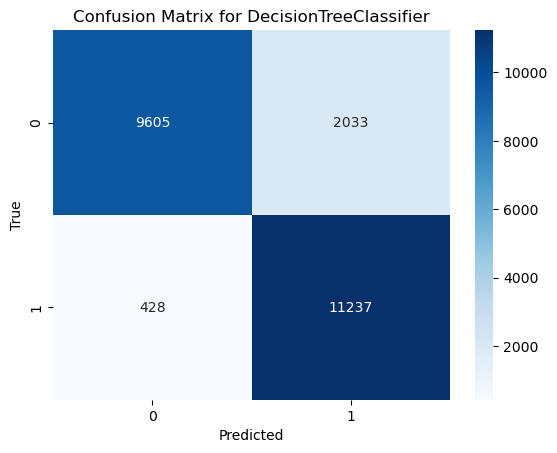

LogisticRegression accuracy: 68.91%


C:\Users\GEETHA PAVAN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


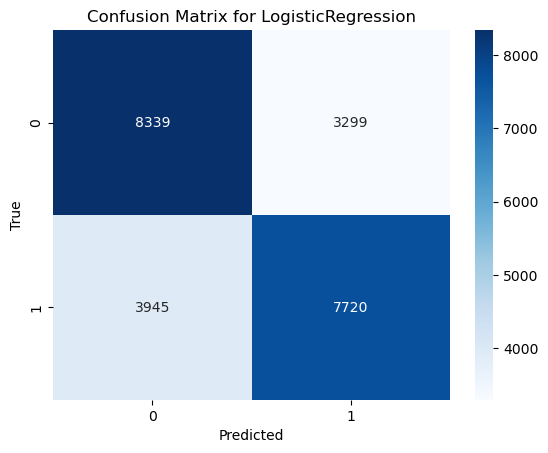

GradientBoostingClassifier accuracy: 74.42%


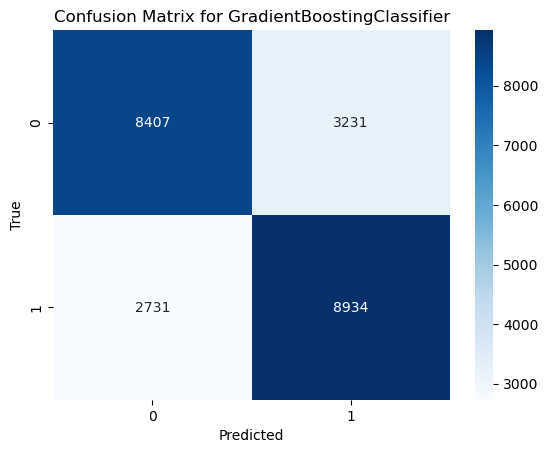

AdaBoostClassifier accuracy: 72.17%


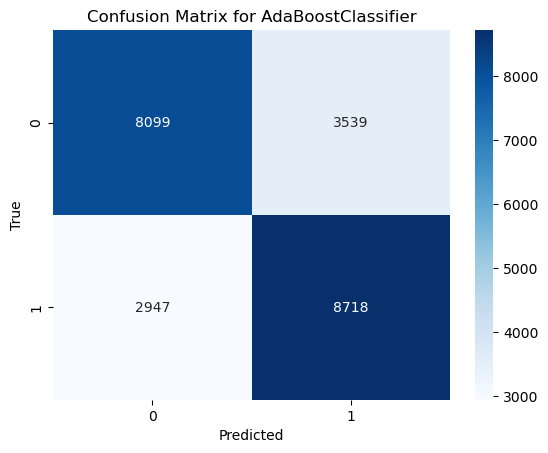

ExtraTreesClassifier accuracy: 93.55%


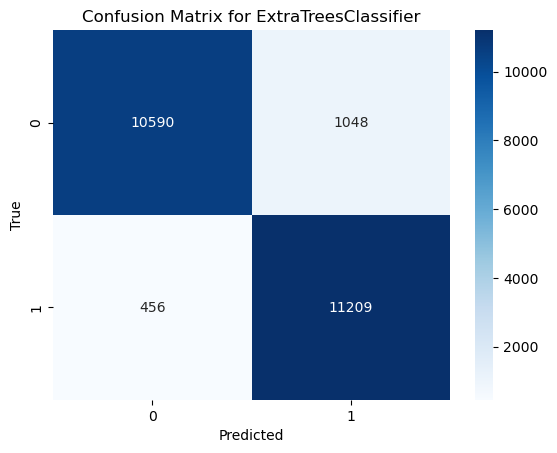

BaggingClassifier accuracy: 92.10%


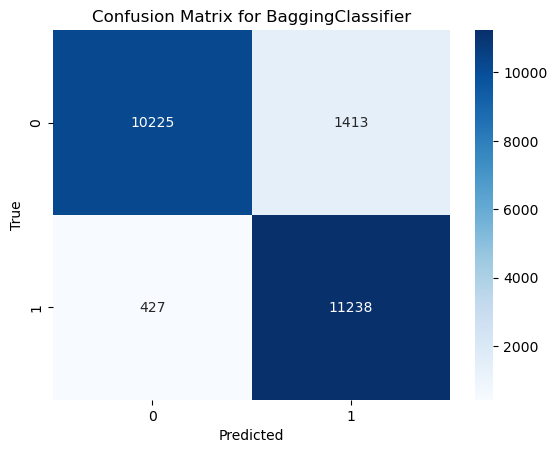

RandomForestClassifier accuracy: 93.16%


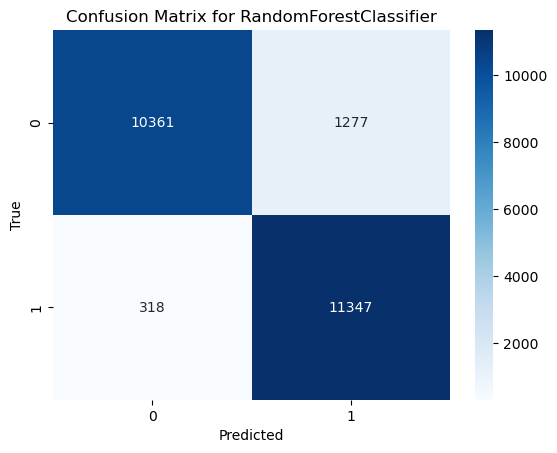

C:\Users\GEETHA PAVAN\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNeighborsClassifier accuracy: 80.55%


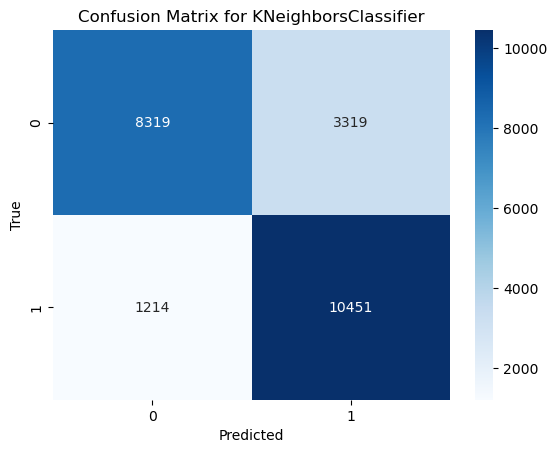

GaussianNB accuracy: 60.07%


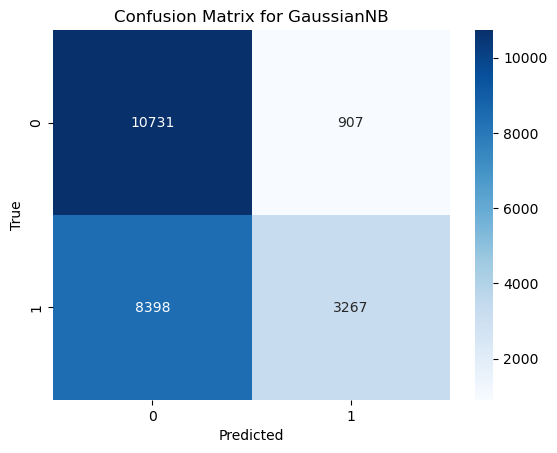

In [24]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append((accuracy, clf))
    print(f"{clf.__class__.__name__} accuracy: {accuracy * 100:.2f}%")
    # Plot the confusion matrix for the current classifier in the list
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for {clf.__class__.__name__}")
    plt.show()

In [25]:
# Get the classifiers sorted by accuracy
sorted_classifiers = sorted(zip(classifiers, accuracies), key=operator.itemgetter(1), reverse=True)

# Get the top 2 classifiers
top_classifiers = [clf for clf, _ in sorted_classifiers[:2]]

In [26]:
# Test the top 2 classifiers
y_preds = []
for clf, _ in sorted_classifiers[:2]:
    y_pred = clf.predict(X_test)
    y_preds.append(y_pred)
    print(f"{clf.__class__.__name__} accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

ExtraTreesClassifier accuracy: 93.55%
RandomForestClassifier accuracy: 93.16%


In [27]:
# Take the average of the predictions from the top 2 classifiers
y_pred = np.round(np.mean(y_preds, axis=0))

In [28]:

# Evaluate the ensemble model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9412951122173111


In [29]:

# Accuracy: 0.9412951122173111 for rf n_estimators=160,et n_estimators=10
# Accuracy: 0.9386345105780372

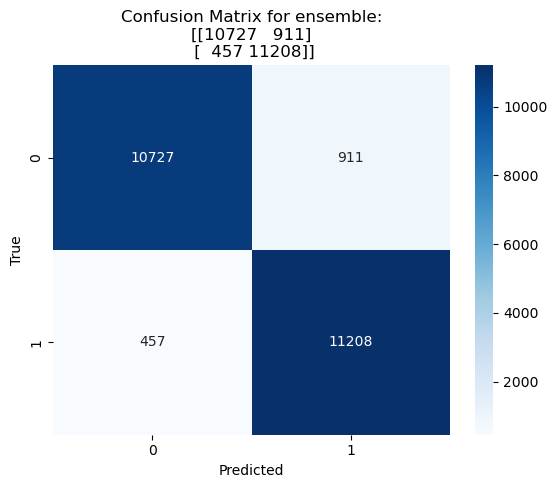

In [30]:
# Plot the confusion matrix for the current classifier in the list
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
# print(f"Confusion matrix for the ensemble:\n{cm}")
plt.title(f"Confusion Matrix for ensemble:\n{cm}")
# plt.title(f"Confusion Matrix for {clf.__class__.__name__}")
plt.show()

In [32]:
# Assuming X_test and y_test are the input data used in the code
y_true = y_test

In [33]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)

In [34]:
# Print the results
print("Confusion Matrix:")
print(cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)

Confusion Matrix:
[[10727   911]
 [  457 11208]]
Precision: 0.9248287812525786
Recall: 0.9608229747106729
F1-score: 0.9424823410696267
Accuracy: 0.9412951122173111
